# Introduction

- Introduction to the perturbation methods (state and step-size perturbation).
- Create Izhikevich example.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from scipy.stats import norm, lognorm

In [3]:
from neuroprobnum.utils import data_utils
from neuroprobnum.utils import plot_utils as pltu
from neuroprobnum.solver import ode_solver

# Toy problem

In [4]:
from neuroprobnum.models import test_models
model = test_models.ToyModel1(a=1, b=3, c=3)

In [5]:
plot_ts = np.linspace(0, 3, 101)
plot_ys = model.eval_y(t=np.linspace(0, 3, 101))

from scipy.integrate import solve_ivp
num_sol = solve_ivp(fun=model.eval_ydot, t_span=(plot_ts[0], plot_ts[-1]), y0=np.array([plot_ys[0]]), t_eval=plot_ts)

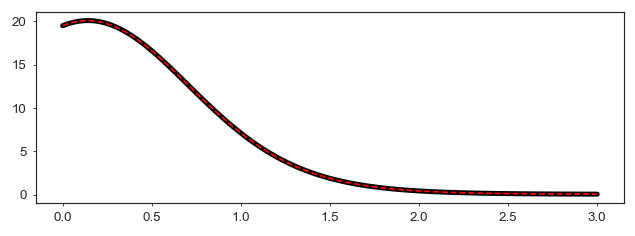

In [6]:
plt.plot(plot_ts, plot_ys, 'k-', lw=3)
plt.plot(num_sol.t, num_sol.y.T, 'r--', lw=1);

## Plot

In [7]:
# Input
t0 = 0
h = 0.1

# Eval
t1 = t0 + h
y0 = model.eval_y(t0)
y1_exact = model.eval_y(t1)
ydot0 = model.eval_ydot(t0, y0)

# Forward Euler
y1_det = y0 + h*ydot0 

# Conrad
sigma = 1
y1_alt = y0 + h*(0.5*ydot0 + 0.5*model.eval_ydot(t1, y1_det))
error = sigma*np.abs(y1_det - y1_alt)
y1_smp_c = y1_det + 0.25

# Abdulle
sigma = 1
dt_pert = sigma*h**1.5 # Bound of uniform distribution
t1a = t1-dt_pert
t1b = t1+dt_pert
t1_smp_a = 0.8*t1a + 0.2*t1b
y1_smp_a = y0 + (t1_smp_a-t0) * ydot0 
abdulle_ln_solver = ode_solver.get_solver(method='FE', pert_method='abdulle_ln', t0=t0, y0=y0, h0=h, odefun=model.eval_ydot, pert_param=sigma)

# Limits
xlims = (t0 - 0.1*h, t1+0.35*h)
ylims = (np.minimum(y0, y1_det) - 0.3*np.abs(y1_det-y0), np.maximum(y0, y1_det) + 0.7*np.abs(y1_det-y0))

### Plot parameters

In [8]:
stages_kw  = {'lw': 0.8, "alpha": 0.7, "ls": '--', "zorder": -20, "c": 'gray'}
exact_kw   = {'lw': 0.8, "alpha": 0.7, "ls": '-',  "zorder": -10}
sol_kw     = {"alpha": 1.0, "ms": 3}
error_kw   = {"alpha": 0.5, "color": 'red', "lw": 1.2, "zorder": -3}
arrowstyle = "Simple,tail_width=1.0,head_width=3,head_length=8"
arrowcolor = 'blue'
dist_kw    = {"zorder": -30, "c": 'darkred'}

### Plot utility functions

In [9]:
def annotate(ax, x, y, xtext, ytext, text, va, ha):
    ax.annotate(text,
        xy=(x, y), xycoords='data', xytext=(xtext, ytext), textcoords='data',
        va=va, ha=ha, bbox=dict(boxstyle="round4", fc="w", ec=(0.9, 0.9, 0.9), alpha=0.8),
        arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=-0.2", fc="w", ec=(0.5, 0.5, 0.5)),
    )

In [55]:
def plot_step(ax, t0, y0, ydot0, t1, y1_det, xlims):
    # Plot points
    ax.plot(t0, y0, 'o', c=arrowcolor, **sol_kw)
    ax.plot(t1, y1_det, marker="o", color= 'green', **sol_kw)
    ax.plot(t0 + h, y1_exact, marker="o", color= 'k', **sol_kw)

    # Plot slope
    arrow = patches.FancyArrowPatch((t0, y0), (t1, y1_det), color=arrowcolor, alpha=.8, lw=0, arrowstyle=arrowstyle, clip_on=False)
    ax.add_patch(arrow)
    ax.text(t0+0.3*h, y0+0.25*h*ydot0, r'$f(t_0, x_0)$', ha='right', va='bottom', c=arrowcolor, clip_on=False) 

    # Ticks
    ax.set_xticks([t0, t1])
    ax.set_xticklabels([r'$t_0$', r'$t_0 + \Delta t$'], fontsize=plt.rcParams['font.size'])
    
    # Limits and labels
    ax.set_xlim(xlims)
    ax.set(ylabel='x(t)', xlabel='t')

    # Plot true solution
    true_ts = np.linspace(t0, xlims[1], 101)
    true_ys = model.eval_y(true_ts)

    ax.plot(true_ts, true_ys, c='k', label=r"exact", **exact_kw)

### Conrad's Method

In [56]:
def plot_x_pdf_conrad(ax, ylims, y1_det, error):
    y_pdf_in = np.linspace(ylims[0], ylims[1], 101)
    y_pdf_out = norm(loc=y1_det, scale=error).pdf(y_pdf_in)
    ax.plot(y_pdf_out, y_pdf_in, **dist_kw)
    ax.set(xlabel=r'$\rho(x_\mathrm{prb}(t + \Delta t)$)')
    ax.set_xlim(0, None)

In [57]:
def plot_conrad(axs):
    assert axs.size == 2
    
    plot_step(axs[0], t0, y0, ydot0, t1, y1_det, xlims)
    axs[0].plot(t1, y1_smp_c, color='darkred', marker='o', **sol_kw)
    plot_x_pdf_conrad(ax=axs[1], ylims=ylims, y1_det=y1_det, error=error)
    axs[0].set_yticks([y0, y1_exact])
    axs[0].set_yticklabels([r'$x_0$',r'$x_1$'], fontsize=plt.rcParams['font.size'])
    
    annotate(ax=axs[0], x=t1, y=y1_det, xtext=np.mean(xlims), ytext=ylims[-1],
             text=r'$x_\mathrm{det}(t_0 + \Delta t)$', va="top", ha="right")
    annotate(ax=axs[0], x=t1, y=y1_exact, xtext=np.mean(xlims)*1.1, ytext=ylims[0]*1.002,
             text=r'$x_1 = x_\mathrm{exact}(t_0 + \Delta t)$', va="bottom", ha="left")
    annotate(ax=axs[0], x=t1, y=y1_smp_c, xtext=xlims[-1]*1.01, ytext=y1_smp_c*1.01,
             text=r'$x_\mathrm{prb}(t_0 + \Delta t)$', va="bottom", ha="right")
    
    axs[0].plot([t1, t1], [ylims[0], ylims[1]], **stages_kw)
    for ax in axs:
        ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [y1_exact, y1_exact], **stages_kw)

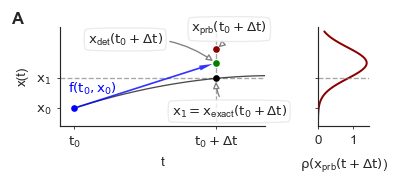

In [58]:
fig, axs = pltu.subplots(2, 1, gridspec_kw=dict(width_ratios=(4, 1)), ysizerow=1.4, yoffsize=0, sharey='row', xsize='col')
sns.despine()

# Plot
plot_conrad(axs)
    
pltu.set_labs(axs=axs[0], panel_nums=['A'], panel_num_space=8)
plt.tight_layout(pad=0.3, w_pad=2)
fig.align_labels()
plt.show()

### Abdulle's method

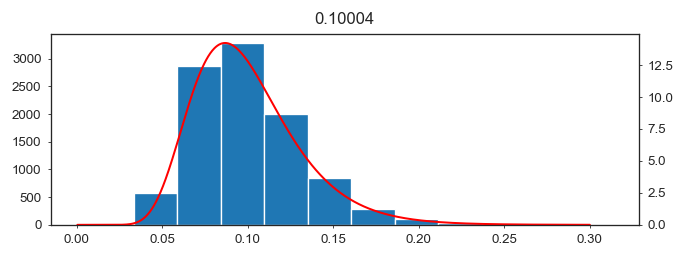

In [59]:
sample_dist = [np.exp(np.random.normal(loc=abdulle_ln_solver._pert_mu,
                                       scale=abdulle_ln_solver._pert_sigma)) for _ in range(10000)]

t_pdf_in = np.linspace(0, 3*h, 1001)[1:]

ax = plt.subplot(111)
ax.set(title=f"{np.mean(sample_dist):.5f}")
plt.hist(sample_dist, bins=11)
ax = ax.twinx()
plt.plot(t_pdf_in,
         lognorm(scale=np.exp(abdulle_ln_solver._pert_mu), s=abdulle_ln_solver._pert_sigma).pdf(t_pdf_in), c='r')
ax.set_ylim(0, None)
plt.show()

In [60]:
def plot_t_pdf(ax, t_pdf_in, t_pdf_out):
    ax.plot(t_pdf_in, t_pdf_out, **dist_kw)
    ax.set(xlabel='t', ylabel=r'$\rho(\zeta_t)$')
    ax.set_xlim(xlims)
    ax.set_ylim(0, t_pdf_out.max()*1.3)

    
def plot_t_pdf_lognormal(ax, xlims, t0, t1):
    t_pdf_in = np.linspace(0, xlims[1], 1001)[1:]
    t_pdf_out = lognorm(scale=np.exp(abdulle_ln_solver._pert_mu), s=abdulle_ln_solver._pert_sigma).pdf(t_pdf_in)
    plot_t_pdf(ax, t_pdf_in, t_pdf_out)
    ax.set_xticks([t0, t1])
    ax.set_xticklabels(["0", r"$\Delta t$"], fontsize=plt.rcParams['font.size'])
    
    
def plot_x_pdf_lognormal(ax):
    samples_y_pdf_out = y0 + np.exp(np.random.normal(loc=abdulle_ln_solver._pert_mu, scale=abdulle_ln_solver._pert_sigma, size=(300000))) * ydot0
    sns.histplot(ax=ax, y=samples_y_pdf_out, color='darkred', kde=True, stat='density', line_kws=dict(alpha=0.75), bins=15, element="step")
    ax.set(xlabel=r'$\rho(x_\mathrm{prb}(t + \Delta t)$)')

In [109]:
def plot_abdulle(axs):
    assert axs.shape == (2, 2)
    
    plot_step(axs[1,0], t0, y0, ydot0, t1_smp_a, y1_smp_a, xlims)
    axs[1,0].plot([t1_smp_a, t1], [y1_smp_a, y1_smp_a], '-', color='darkred', alpha=0.5)
    axs[1,0].plot(t1_smp_a, y1_smp_a, color='green', marker='o', **sol_kw, markerfacecolor=(1, 1, 1, 0))
    axs[1,0].plot(t1, y1_smp_a, color= 'darkred', marker='o', **sol_kw)
    
    
    axs[1,0].set_xticks([t0, t1, t1_smp_a])
    axs[1,0].set_xticklabels([r'$t_0$', r'        $t_0 + \Delta t$', r'$t_0 + \zeta_t$      '], fontsize=plt.rcParams['font.size'])
    axs[1,0].set_yticks([y0, y1_exact])
    axs[1,0].set_yticklabels([r'$x_0$', r'$x_1$'], fontsize=plt.rcParams['font.size'])
    
    annotate(ax=axs[1,0], x=t1_smp_a, y=y1_smp_a, xtext=xlims[0]+h*0.1, ytext=ylims[-1]*0.99, text=r'$x_\mathrm{det}(t_0 + \zeta_t)$', va="top", ha="left")
    annotate(ax=axs[1,0], x=t1, y=y1_exact, xtext=np.mean(xlims)*1.1, ytext=ylims[0]*1.005, text=r'$x_1 = x_\mathrm{exact}(t_0 + \Delta t)$', va="bottom", ha="left")
    annotate(ax=axs[1,0], x=t1, y=y1_smp_a, xtext=xlims[-1]*1.05, ytext=ylims[-1]*0.99, text=r'$x_\mathrm{prb}(t_0 + \Delta t)$', va="top", ha="right")
    
    plot_t_pdf_lognormal(axs[0,0], xlims, t0, t1)
    plot_x_pdf_lognormal(axs[1,1])

    axs[0,0].set_xlabel(None)
    axs[0,1].axis('off')
    
    axs[1,0].plot([t1, t1], [ylims[0], ylims[1]], **stages_kw)
    for ax in axs[1,:]:
        ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [y1_exact, y1_exact], **stages_kw)
        
    axs[0,0].axvline(t1, **stages_kw)

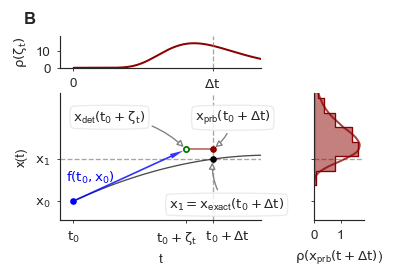

In [110]:
fig, axs = pltu.subplots(2, 2, gridspec_kw=dict(width_ratios=(4, 1), height_ratios=(1, 4)), ysizerow=1.1, yoffsize=0, sharey='row', xsize='col')
sns.despine()

for ax in axs[:, 0]:
    ax.set_ylim(ylims)

plot_abdulle(axs)

pltu.set_labs(axs=axs[0, 0], panel_nums=['B'], panel_num_space=5, panel_num_y=1.3, panel_num_va='bottom')
plt.tight_layout(pad=0.3, w_pad=2, h_pad=0.2)
plt.show()

# A real model, the Izhikevich neuron

In [18]:
from neuroprobnum.models.izhikevich import INmodel, INParameters

neuron_parameters, stimulus_parameters, t_parameters = INParameters().select_mode('Tonic spiking')
neuron = INmodel(neuron_parameters, stimulus_parameters)

In [19]:
from neuroprobnum.generator.generator_in import DataGeneratorIN

gen = DataGeneratorIN(
    y0=neuron.y0, t0=11, h0=0.1, tmax=15,
    gen_acc_sols=True, return_vars=['ys', 'events'],
    model=neuron, n_samples=40, base_folder='_data'
)

  0%|          | t=0.00000/4=tmax [00:00<?]

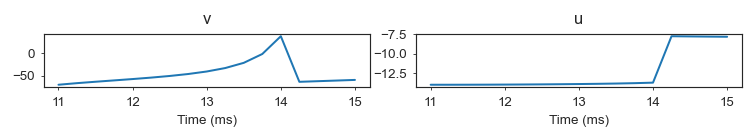

In [20]:
# Deterministic solution
soldet = gen.gen_det_sol(method='FE', adaptive=0, step_param=t_parameters['dt'], plot=True)

  0%|          | 0/40 samples [00:00<?]

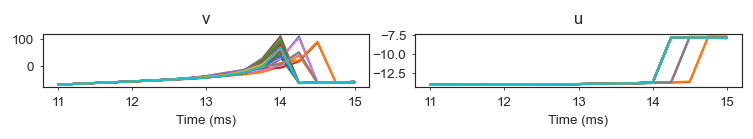

In [21]:
# Probabilistic solution
solprob = gen.gen_sol(method='FE', adaptive=0, pert_method='conrad', step_param=t_parameters['dt'], plot=True)

## Plot

In [22]:
def plot_IN_traces(ax):
    """Plot traces of Izhikevich neuron"""
    example_kws = {'lw': 0.8, "alpha": 0.7, "marker": '.', "ms": 3.5, "ls": '-'}
    determi_kws = {'lw': 0.8, "alpha": 0.7, "marker": '.', "ms": 3.5, "ls": '--'}
    
    ax.plot(solprob.ts-gen.t0, solprob.get_ys(yidx=0, sampleidx=1), **example_kws, clip_on=False, c='C1')
    ax.plot(solprob.ts-gen.t0, solprob.get_ys(yidx=0, sampleidx=5), **example_kws, clip_on=False, c='darkred')
    ax.plot(solprob.ts-gen.t0, soldet.get_ys(yidx=0), c='green', **determi_kws, clip_on=False)
    
    # Annotate and 30 mV line.
    ax.axhline(30, c='gray', ls=':', lw=0.8)
    ax.set_ylabel('v(t)')
    ax.set_xlabel('Time (ms)')
    ax.set_ylim(-75, 75)

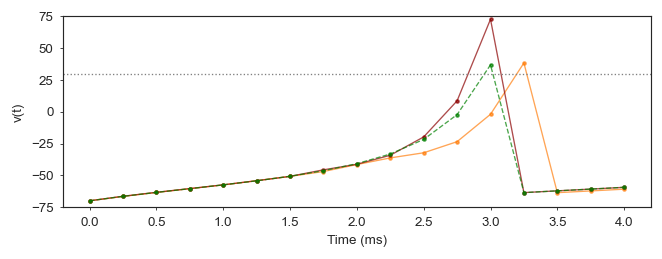

In [23]:
plot_IN_traces(plt.subplot(111))

# Figure

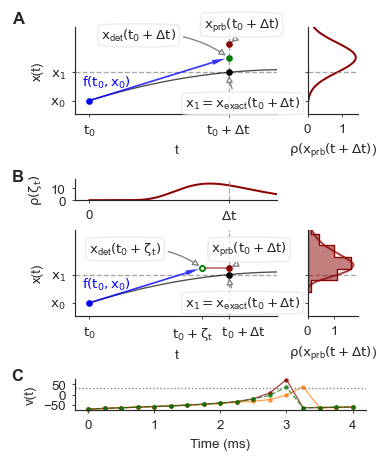

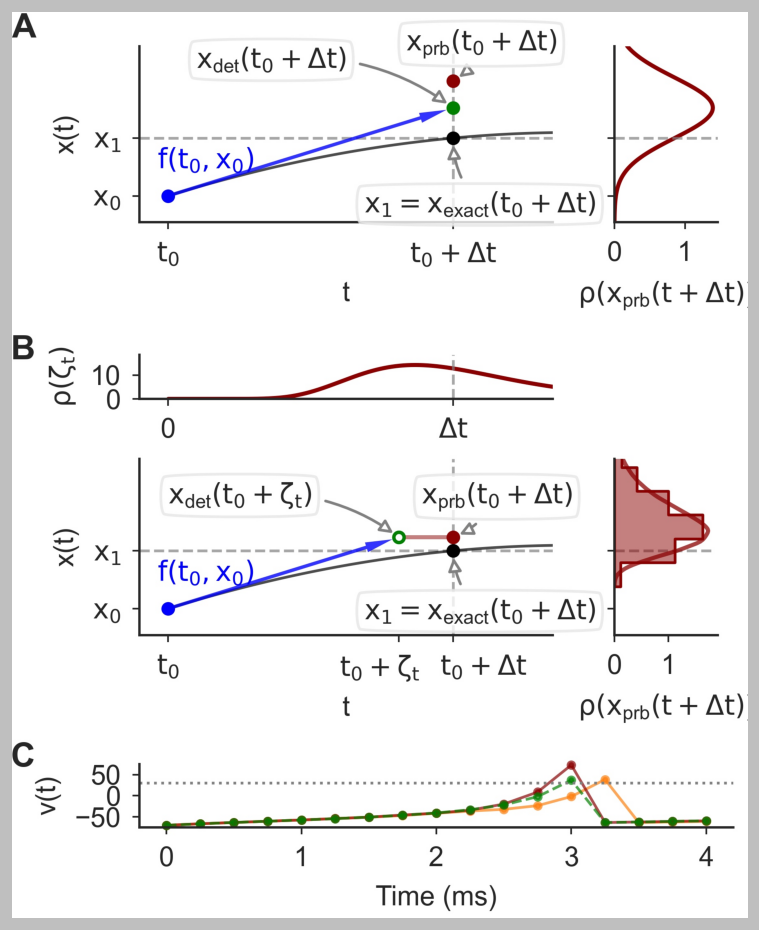

In [117]:
fig, axs = pltu.subplots(2, 3, xsize='col', gridspec_kw=dict(width_ratios=(4, 1), height_ratios=(4, 1, 4)), ysizerow=0.9, yoffsize=1., sharey='row')

for ax in axs[[0, 2], :].flat:
    ax.set_ylim(ylims)

# Plot methods
plot_conrad(axs[0, :])
plot_abdulle(axs[1:3, :])

plt.tight_layout(pad=0.3, w_pad=0.3, h_pad=0.1, rect=[0.03, 0.2, 0.97, 0.99])
pltu.move_box(axs[1,:], dy=-0.04)

# Traces
ax = fig.add_axes([np.array(axs[0,0].get_position())[0,0], 0.1, 0.98-np.array(axs[0,0].get_position())[0,0], 0.07])
plot_IN_traces(ax)

sns.despine()

pltu.set_labs(axs=[axs[0,0], axs[1,0], ax], panel_nums='auto', panel_num_space=11, panel_num_y=1.1, panel_num_va='center')
pltu.savefig("Fig1")
plt.show()
pltu.show_saved_figure(fig)